# Sampling, Mixing, and Other Things DJs Also Do

Sampling and mixing are two key ideas in Digital Signal Processing (DSP).  In fact, they're fundamental primitives in the SDR toolkit, basic building blocks, like $\mathtt{atof()}$ or $\mathtt{.sort()}$ in other environments.  We'll introduce these two ideas here, along with some closely related concepts that are crucial to building non-trivial signal pipelines.

We will also look at a few other key concepts in this chapter: interpolation, the frequency domain, and a (very) brief intro to filters.

In [1]:
%pylab inline
pylab.rcParams["figure.figsize"] = (15,5)

import scipy.signal

Populating the interactive namespace from numpy and matplotlib


## Sampling

"Sampling" is the first step in any DSP pipeline, whether it's for music, radio, or generic systems control.  It converts a continuous, analog input into a set of discrete-valued, discrete-time datapoints.  The word "sampling" can also refer to "resampling," where we convert data from one timebase to another.  For instance, if we have a signal sampled at 16kHz, but want to take it down to 8kHz, we "resample it down," or "downsample" to get the same signal at the lower sampling rate.  Similarly, if we want to take that 16kHz signal and make it 48kHz, we can "upsample" it to get up to 48kHz.  But, if someone just says "sampling," they're probably referring to the initial capture of our signal.

Let's start with simple sampling.  In our FM example program, we got our samples off the air using an RTL-SDR radio receiver. For this chapter, we're going to "sample" an ideal mathematical function in pure software.

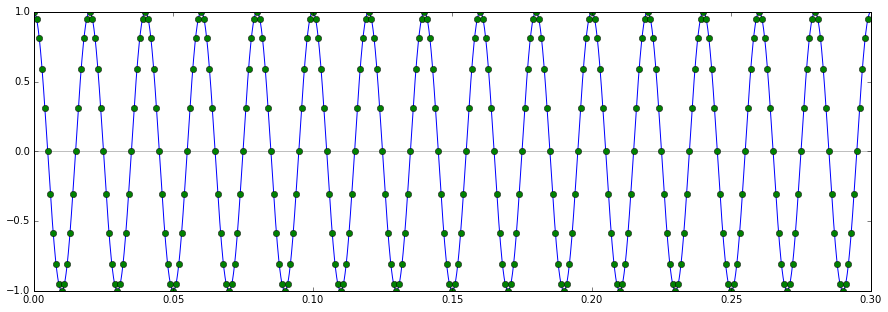

In [2]:
Fs = 1000 # 1kHz sampling rate

f = 50 # 50Hz signal


t_min = 0.0
t_max = 0.3 # look at a graph from 0~100ms

# Let's make a much finer-grain "actual" signal to sample from
actual_t = np.arange(t_min,t_max, 1.0/(10*Fs)) # oversample by 10x
actual_cosine = np.cos(2*np.pi*actual_t * f)

# And now we generate a less fine-grained "sampled" version
sample_t = np.arange(t_min, t_max, 1.0/Fs)
sample_cosine = np.cos(2*np.pi*sample_t * f)

# And we compare the two
axhline(0, color="grey", alpha=0.5)
plot(actual_t, actual_cosine)
plot(sample_t, sample_cosine, 'o')

As you can see, the green dots of our sampled version of the waveform follow the "smoother" version very closely.  What we've done here is an idealized version of sampling a sine wave in the real world.  We'll use these idealized signals throughout the rest of this chapter.  Considering the effects of noise is left as an exercise to the reader in the problem set; this exercise is strongly recommended!

## Introducing the Frequency Domain

Another way to evaluate the results of sampling is to look at the Power Spectral Density (PSD).  This shows us a graph of how much power there is at each frequency in our input signal.  A PSD lets us see the relative intensity of the various frequencies within a signal.  Since our signal only has one tone in it, we expect to get a nice sharp peak at 50Hz, with zeros everywhere else.  Unfortunately, because our signal is relatively short, we're going to get "skirts" coming off of our peak, so it's more like a mountain than a needle.

Using PSDs is pretty straightforward: we just do $\mathtt{psd()}$ on our signal.  I like to add the sample rate parameter, which labels the x-axis with actual frequencies, instead of fractions.  It's also sometimes helpful to add the NFFT parameter, which tells psd how many buckets to draw: this can be great for sharpening up the skirts on the sides of signals.

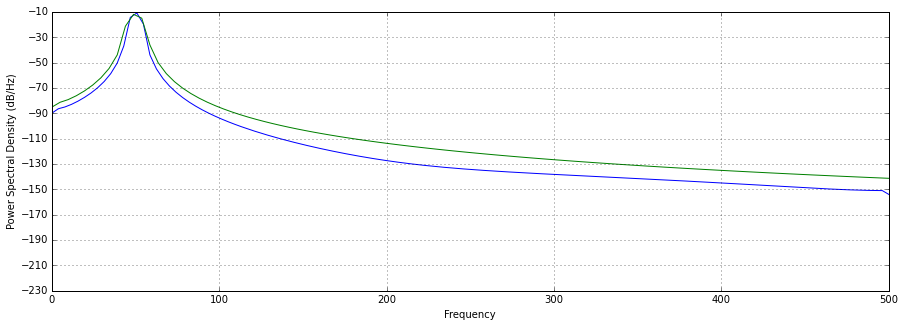

In [145]:
psd(sample_cosine, NFFT=256, Fs=Fs)
psd(actual_cosine, NFFT=2048, Fs=Fs*10)
xlim(0,500); None

As you can see, our two signals line up pretty well in the frequency domain!  Let's do a bit more experimenting to get a feel for PSDs.  Next up: let's have two tones:

In [4]:
t = np.arange(0,100000)/float(Fs) # 100k samples, to let us try many NFFT= values

def cw(f):
    return np.cos(2*np.pi*t * f)

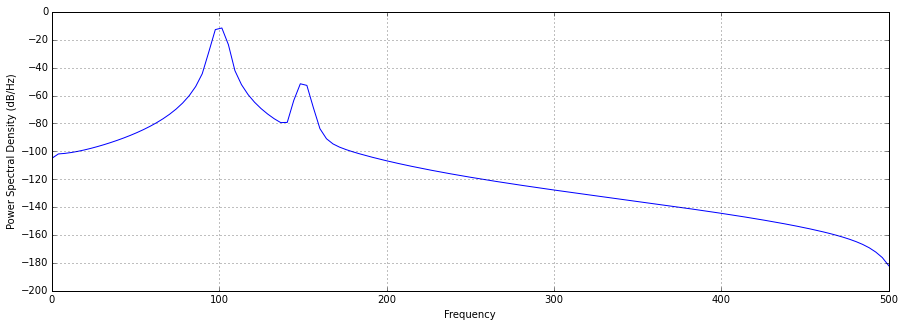

In [5]:
psd(cw(100) + 0.01 * cw(150), Fs=Fs); None

Note that the signal at 150Hz is only 1% the amplitude of the signal at 100Hz, but it's still really clearly visible.  PSDs are very sensitive, which is part of what makes them so valuable.  This view of signals is called the "frequency domain," because we're looking at the signal as a function of frequencies.  Our first view of the data, where we see the raw waveform, is called the "time domain."  Going forward, we'll look at the frequency domain more often than the time domain, so you'll have lots of opportunities to figure out the details.

Pedantic note: "Power" here is more or less how you think of it both colloquially and technically, but in our PSDs it's probably not quite either.  This is due to some vagaries in how we define power in a system like ours, but, honestly, it doesn't matter to us.  We're only after relative intensities, so we're going to ignore the fact that no energy is actually delivered and we're just using amplitude squared instead.

## Downsampling

The first bit resampling we'll look at is "downsampling," also known as "decimation."  This is a really straightforward process: we simply choose one out of every N samples, and throw the rest on the floor.  In doing so, we change our sample rate from $F_s$ to $\frac{F_s}{N}$.  The implementation is particularly simple in numpy, as it has an array access method with the ability to skip built in:

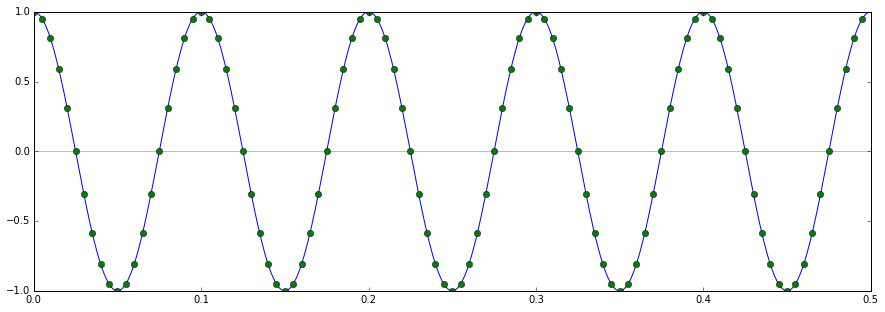

In [129]:
t = np.arange(0, 0.5, 1.0/Fs)
f = 10

axhline(0, color="grey", alpha=0.5)

signal = np.cos(2*np.pi*t * f)
plot(t,signal)


N = 5
downsampled = signal[::N]
plot(t[::N], downsampled, 'o')
Fs_d = Fs/N

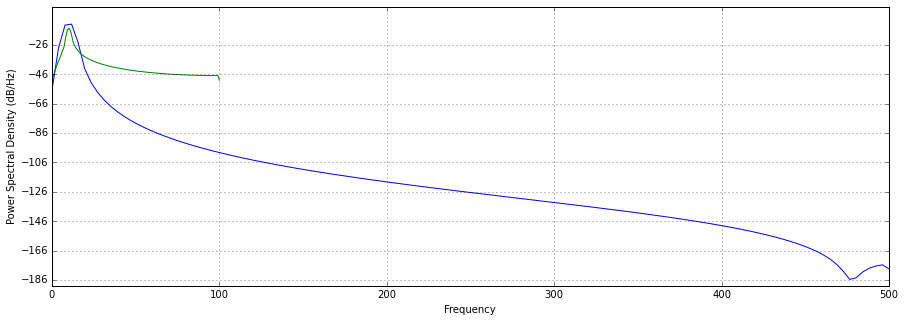

In [130]:
psd(signal, Fs=Fs)
psd(downsampled, Fs=Fs_d)
ylim(-190, 0); None

Let's make this a bit easier to see all in one place:

In [133]:
def plot_alias_check(t1,y1,Fs, t2,y2,Fs_d):
    subplot2grid((1,5), (0,0), colspan=3)
    axhline(0, color="grey", alpha=0.5)
    axis("off")
    
    plot(t1,y1)
    plot(t2,y2, 'o')
    title("Signal, with downsampled points highlighted")
    ylim(-1.1,1.1)
    xlim(0, t2[20])
    
    subplot2grid((1,5), (0,3), colspan=2)

    psd(y1, Fs=Fs)
    psd(y2, Fs=Fs_d)
    xlim(0, 2*Fs_d)
    #ylim(-190,0)
    ylabel("")

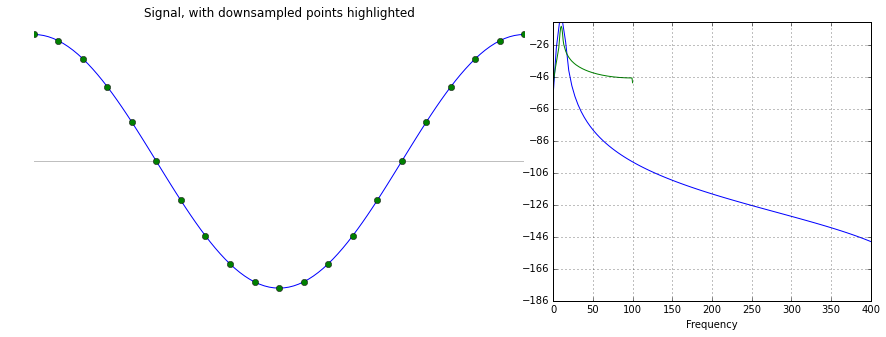

In [134]:
plot_alias_check(t,signal,Fs, t[::N],downsampled,Fs_d)

(Fun Fact: Decimation is the ancient Roman practice of having nine out of ten soldiers kill the other one, in order to punish the whole group for things like abandoning their place in battle.  Over the years, its usage has changed, obviously, as we can now "decimate" by fractions besides one in ten.  Also, it can apply to things besides soldiers.  Finally, decimation was done at random, by drawing lots.  We can't decimate at random, as that would cause phase noise.)

## Aliasing -- the gotcha of downsampling

Let's look at what happens if we decimate too aggressively.  We'll create an input signal at 125Hz, and then sample it at 200Hz.  The 125Hz signal should still "fit inside" the 200Hz sample rate, right?  Let's try it, and evaluate using the tools above:

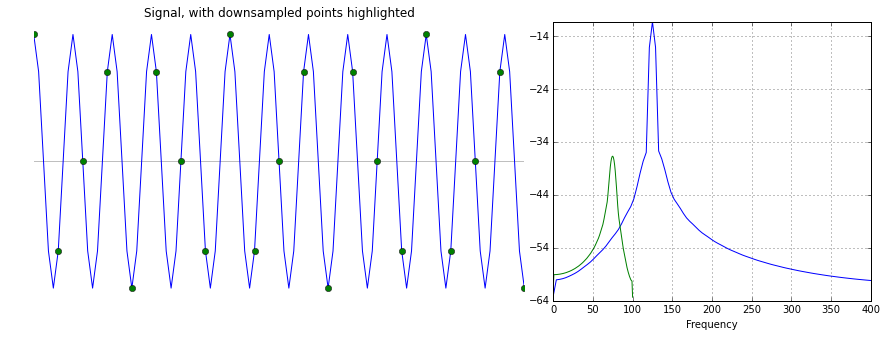

In [135]:
t = np.arange(0, 0.2, 1.0/Fs)
f = 125


signal = np.cos(2*np.pi*t * f)

N = 5
downsampled = signal[::N]
Fs_d = Fs/N

plot_alias_check(t,signal,Fs, t[::N],downsampled,Fs_d)

#subplot2grid((1,5), (0,0), colspan=3)
#plot(t,signal)
#plot(t[::5], downsampled, 'o')
#axhline(0, color="grey", alpha=0.5)
#axis("off")
#ylim(-1.1,1.1); Fs_d


#subplot2grid((1,5), (0,3), colspan=2)

#psd(signal, Fs=Fs)
#psd(downsampled, Fs=Fs_d); 
#ylabel("")
#xlim(0,200)

That's not right.  Our power seems to have moved from 125Hz down to 75Hz.  What's going on?  Let's look at this in the time domain again.  We'll plot our original signal, then the downsampled signal, and then a 75Hz wave. We can see that all our downsampled points lie on the original signal.  But when we look at the 75Hz signal, we notice that those points all lie right where the two sine waves intersect:

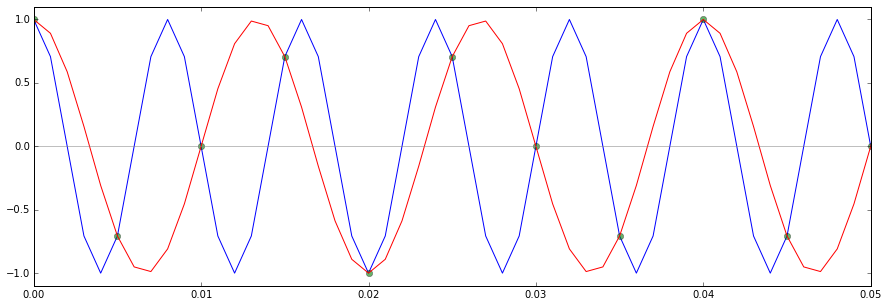

In [136]:
plot(t,signal)
plot(t[::5], downsampled, 'o', alpha=0.6)

plot(t, np.cos(2*np.pi*t * 75))

axhline(0, color="grey", alpha=0.5)
xlim(0,0.05)
ylim(-1.1,1.1); None

This result is called "aliasing," where an input frequency becomes ambiguous after sampling.  What causes this?

Look at our sample points above.  Note that the red 75Hz sine wave goes through all the sample points, and also that it's the lowest frequency wave that can do that.  Any lower frequency wave would miss some of the points, no matter how you tweak the frequency, amplitude, and phase offset.

But: this wasn't a problem before!  With our 10Hz wave, downsampling from 1kHz to 200Hz didn't cause any problems.  We put in 10Hz, we got out 10Hz.  So why is 125Hz magically turning into 75Hz with the same downsampling?  The answer is "frequency folding" happening, over the "Nyquist frequency."

## The Nyquist frequency

The Nyquist frequency (aka "folding frequency") is the highest frequency that can be captured in a discrete-time sampled system.  It's always one half of the sample rate.  So, for a 200Hz sample rate, the highest frequency that can be unambiguously represented is 100Hz.  Anything faster than 100Hz "folds over" at 100Hz.  This is why our 125Hz signal became 75Hz: 125Hz is 25Hz above 100Hz, so it winds up at 100-(125-100) = 75Hz.

Why is the Nyquist frequency a limit?  The easiest intuitive explanation is that we're trying to capture the "essence" of continuous sine waves in our samples.  The essential thing about a sine wave is that it goes up, then goes down.  If you want to capture it unambiguously, you need to be able to see it go all the way up and then all the way down.  This can be done with just two (carefully timed) samples per cycle.

Let's play with this a bit, looking at our example above with a few different folding frequencies:

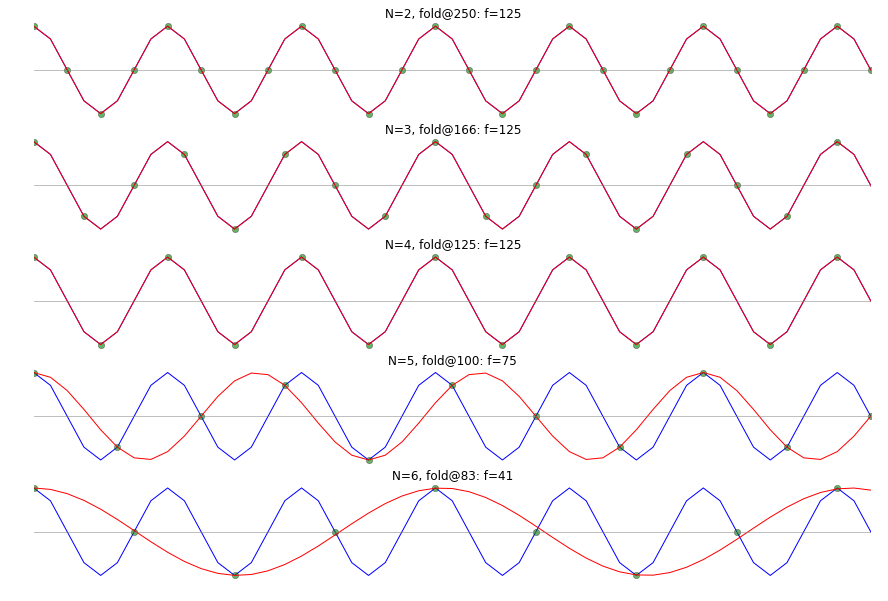

In [88]:
figure(figsize=(15,10))
for i,N in enumerate([2,3,4,5,6]):
    subplot(5,1,i+1)
    
    plot(t,signal)
    plot(t[::N], signal[::N], 'o', alpha=0.6)

    F_fold = Fs/N/2.0
    f_folded = f
    if f > F_fold:
        f_folded = F_fold*2 - f
    plot(t, np.cos(2*np.pi*t * f_folded))

    axhline(0, color="grey", alpha=0.5)
    xlim(0,0.05)
    ylim(-1.1,1.1); None
    title("N=%d, fold@%d: f=%d" % (N, F_fold, f_folded))
    axis('off')

As the downsampling rate increases (ie: as N gets bigger), the dots are spread further and further apart.  At N=4, the dots are literally just barely capturing the waveform.  Once we get to N=5, they are spaced far enough apart that they no longer fit within a single wavelength.  This means that we wind up reconstructing a lower-frequency wave from them.

It may be worthwhile to spend more time playing with these.  Try using a frequency of roughly Fs/100, so you can look at lots of downsampling rates in the ballpark of N=50.  This should help you see the "stretching out" of the wave as you pass the Nyquist frequency.

## Upsampling (Interpolation)

We now have a rough handle on downsampling, which is useful.  But what if we want to increase our sample rate, instead of decreasing it?  This means that every sample in our input is now N samples in our output.  The obvious thing to do is to just repeat every sample N times in a row.  Let's try "undoing" decimation in this way:

In [138]:
t = np.arange(0, 0.5, 1.0/Fs)
f = 10

signal = np.cos(2*np.pi*t * f)

N = 5
downsampled = signal[::N]
Fs_d = Fs/N

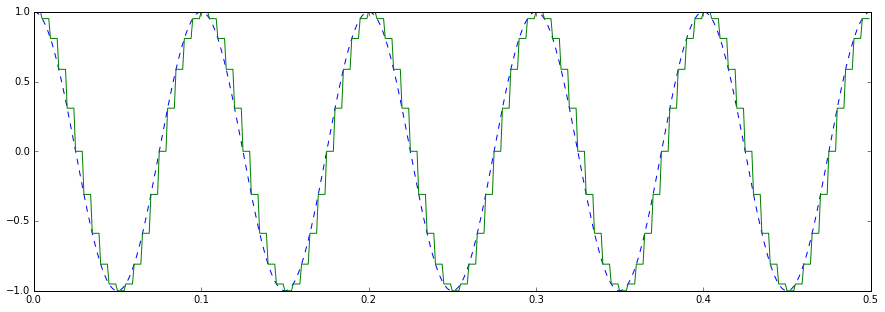

In [139]:
upsampled = np.repeat(downsampled, N)

plot(t,signal, '--')
plot(t,upsampled)


Looking at it in the time domain, it looks a bit rough around the edges (literally).  It's only when we look at it in the frequency domain that we see some problems pop up:

(-150, 0)

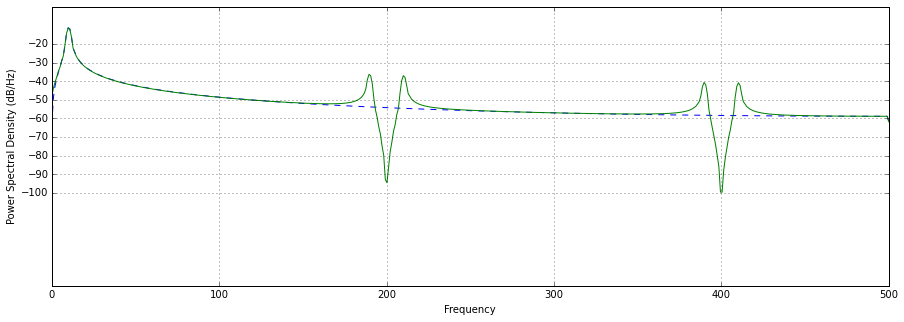

In [140]:
psd(signal, linestyle='--', Fs=Fs, NFFT=1024)
psd(upsampled, Fs=Fs, NFFT=1024); None
ylim(-150, 0)

As you can see, we now have some extra humps popping up in the higher frequency ranges.  This makes some sense, if you think about what it takes to get those nice sharp vertical and horizontal lines.  If we could smooth over those straight line segments a bit, it might go better.  A first option is to try trivial local rolling averages:

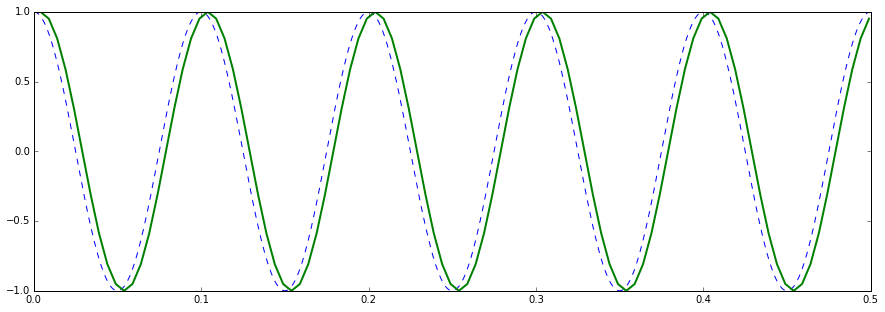

In [10]:
# This is usually the easiest and fastest way to get an N-way rolling mean
upsampled_cs = np.cumsum(upsampled)
upsampled_smoothed = (upsampled_cs[N:] - upsampled_cs[:-N])/N

plot(t,signal, '--')
plot(t[N:],upsampled_smoothed, linewidth=2)

Visually, this looks pretty darned good in the time domain!  If we double-check in the frequency domain, though, we see we still have some little tiny bumps out there:

(-90, 0)

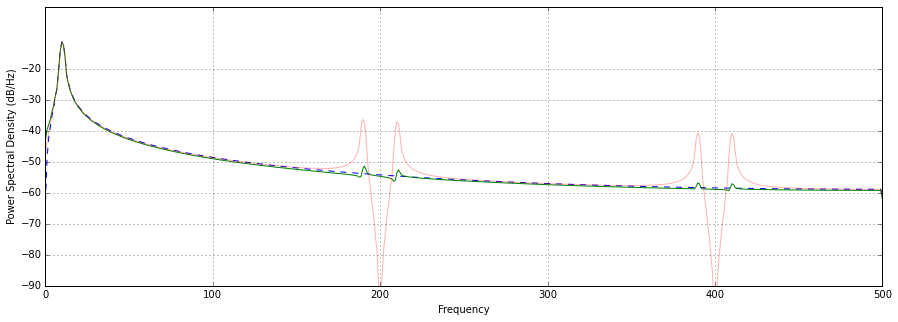

In [11]:
psd(signal, linestyle='--', Fs=Fs, NFFT=1024)
psd(upsampled_smoothed, Fs=Fs, NFFT=1024); None
psd(upsampled, Fs=Fs, NFFT=1024, alpha=0.3); None
ylim(-90, 0)

It's clear that this is better than it had been, but it's still sub-optimal.  What we really want to do is to Low-Pass Filter (LPF) the data and cut off those lumps.

## Filtering

Filtering is 

(-150, 0)

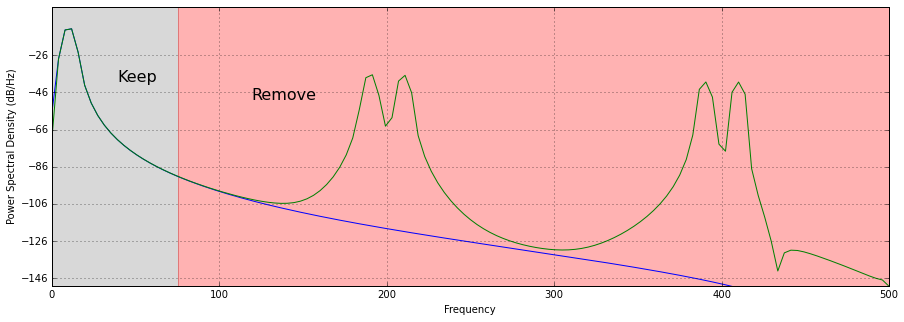

In [23]:
psd(signal, Fs=Fs); None
psd(upsampled, Fs=Fs); None
axvspan(0, 75, color="grey", alpha=0.3)
axvspan(75, Fs/2, color="red", alpha=0.3)
text(40, -40, "Keep", fontsize=16)
text(120, -50, "Remove", fontsize=16)

ylim(-150, 0)

We need to filter out all the stuff on the right hand side above.  We'll do this using a low-pass filter.  There are lots of ways to design filters, but we're going to use the Remez algorithm for now, as it's built in to scipy and easy to work with.  Once we step into GNU Radio, we'll have access to more filter design functions, and may use some of them.  For now, we'll keep it simple and just use $scipy.signal.remez$ for everything.

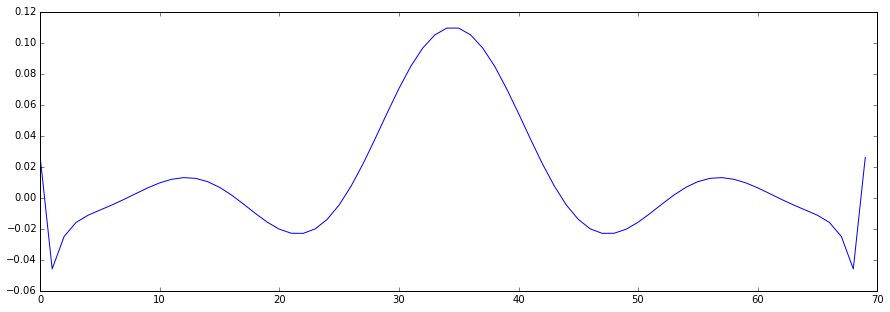

In [31]:
lpf_taps = scipy.signal.remez(70,   # number of taps
                              [0, 50, 60, Fs/2],  # frequency bands
                              [1,0,],              # pass/block for each band
                              Hz = Fs)             # Sample rate

plot(lpf_taps)

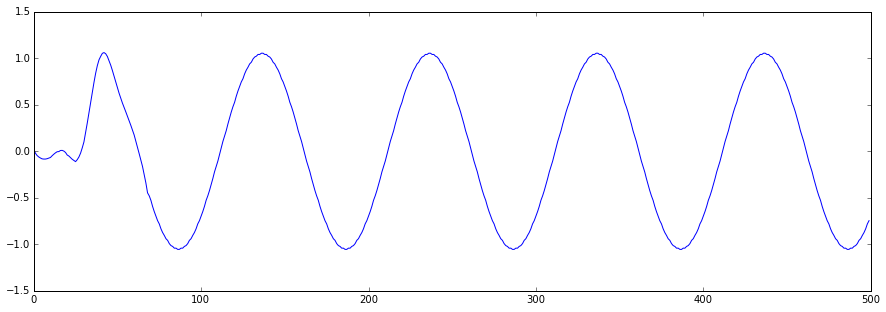

In [37]:
plot(scipy.signal.lfilter(lpf_taps, 1.0, upsampled))

(-70, -10)

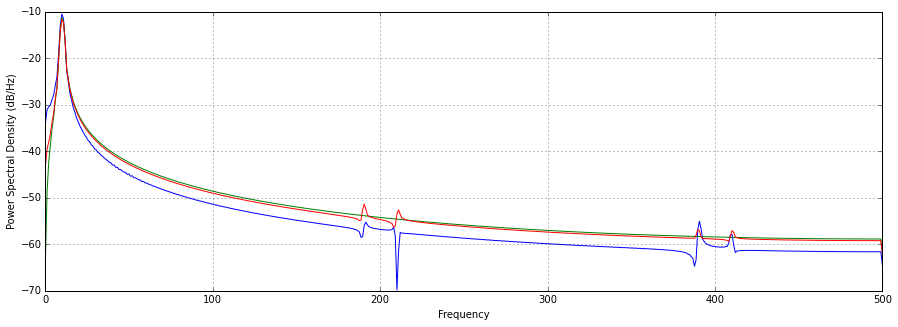

In [38]:
psd(scipy.signal.lfilter(lpf_taps, 1.0, upsampled), Fs=Fs, NFFT=1024); None
psd(signal, Fs=Fs, NFFT=1024)
psd(upsampled_smoothed, Fs=Fs, NFFT=1024); None
ylim(-70, -10)

Note that applying this LPF has focused the power in the signal into the lower-frequency components.  We're getting out a signal that's not quite the same as the one we put in, but are instead getting something that carries just the information we were after: that lower frequency sine wave.  This is what low-pass filters are good for.

We haven't answered one important question, though: where did those little bumps at 200 and 400Hz come from?

#### Problems

With a sample rate of 48kHz, generate a one-second long sine wave at some frequency (2600Hz, maybe, if you need a recommendation).  Using $\mathtt{scipy.io.wavfile.write()}$, save this to a wav file and listen to it with your system's wav player.  Once you've verified the tone, resample the 48kHz file to 44,100 Hz and save that to a new wav file.  Compare the two: can you hear any difference between them?

Also starting with a sample rate of 48kHz, generate a tone at 12,000Hz and save it to a wav file.  Resample this down to 16kHz, and save it to a new wav file.  Does this one sound the same?

Starting with a sample rate of 1024kHz (a common RTL-SDR sample rate), generate a one-second sine wave of frequency 1100Hz.  Resample this down to 44.1kHz and save it to a wav file.  How efficient does the technique you used seem, especially in terms of memory?

Starting with our 1100Hz signal at 1024kHz sample rate, can we improve the efficiency of resampling to 48kHz?  Assuming you're doing an interpolation followed by a downsampling, could you cascade multiple steps and get more efficiency?  What if you downsampled, then interpolated, then downsampled again?  With this specific input signal, could you make it even more efficient?  What if the signal was 9,000Hz instead of 1,100Hz?

We've done idealized sampling in this chapter: all the times are spot-on, and the values are always precise and accurate.  In real systems, none of these three are true.  What is the effect of jitter in the timebase (I'd recommend using $\mathtt{np.random.normal}$ over $\mathtt{np.random.uniform}$ here)?  Specifically, how does it affect the bandwidth of our perfect spike at one frequency?  Using the same evaluation techniques, how does noise in the sampled values affect things?  What if the values have some constant offset?

How does our cumulative-sum rolling mean above work?  In terms of computational overhead, how does it compare to using a filter of [1.0/N, 1.0/N, ..., 1.0/N] via $scipy.signal.lfilter$?